# Сборный проект
## Выявление закономерностей, влияющих на успешность игры

Интернет-магазин хочет выяснить, какие закономерности влияют на успешность игры, чтобы спланировать свои рекламные кампании на следующий год.

Для анализа доступны исторические данные из открытых источников до настоящего момента (~представим, что сейчас конец 2016 года~). За текущий год данные могут быть не полными.



---



## Структура проекта

1. [Начало работы](#start)
2. [Предобработка данных](#preprocessing)
3. [Анализ данных](#analisys)
4. [Проверка гипотез](#hypothesis)
5. [Выводы](#conclusions)



---



## Начало работы
<a id='start'></a>
<a name='start'></a>

Импортируем нужные библиотеки, знакомимся с данными, делаем необходимые для удобной дальнейшей работы базовые вещи

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import missingno as msno
import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/games.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Сразу видим проблему с названиями столбцов - приведём всё к нижнему регистру и переименуем некоторые столбцы для удобства:

In [5]:
df.columns = df.columns.str.lower().str.strip()
df = df.rename(columns={df.columns[2]: 'year'})

Так же видно проблему с типами данных:
- *year* имеет тип float
- *user_score* имеет тип object

Взглянем на пропуски:

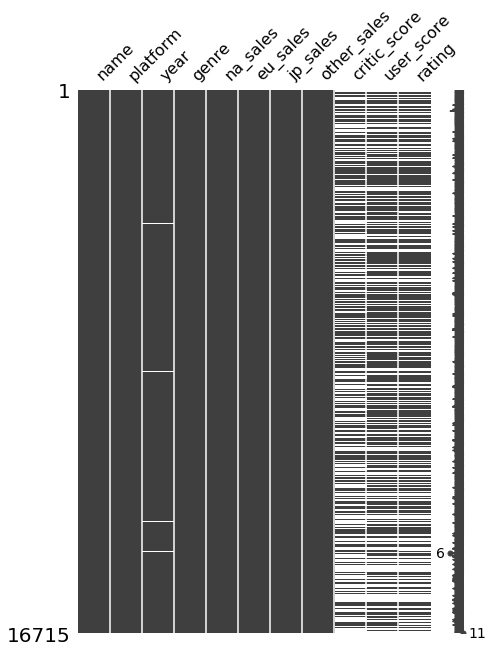

In [6]:
msno.matrix(df, figsize=(7,10))
plt.show()

Видно, что из 11 полей пропуски имеют 6. Так как явно видно только 4, посмотрим поближе:

In [7]:
df.isna().mean()

name            0.000120
platform        0.000000
year            0.016093
genre           0.000120
na_sales        0.000000
eu_sales        0.000000
jp_sales        0.000000
other_sales     0.000000
critic_score    0.513192
user_score      0.400897
rating          0.404786
dtype: float64

Теперь видно, что крайне мало пропусков имеют поля *name* и *year*. Одинаковое количество пропусков наталкивает на мысль о совпадающих пропусках, но займёмся этим в следующем блоке. 

Дальше посмотрим на грубые дубликаты:

In [8]:
df.duplicated().sum()

0

Основные вещи проверили, приступим к предобработке.



---



## Предобработка данных
<a id='preprocessing'></a>
<a name='preprocessing'></a>

Разберёмся с обнаруженными проблемами, обнаружим новые и разберёмся с ними тоже

Обнаруженные проблемы:
- незначительные пропуски полей *name, genre* и *year*
- значительные пропуски полей *critic_score, user_score* и *rating*
- тип данных полей *year* и *rating*

Новые обнаружим при детальном знакомстве с каждым полем позже.

Начнём по порядку.

Незначительные пропуски:

In [9]:
df[['name', 'genre', 'year']].isna().sum()

name       2
genre      2
year     269
dtype: int64

In [10]:
df[df['name'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Предположения подтвердились, пропуски совпадают. Строки всего две, данных никаких нет, смело удаляем:

In [11]:
df = df.dropna(subset=['name'])

Взглянем на *year*. Пропусков тут уже больше (269, это больше полутора процентов), бездумно их удалять может быть плохой идеей. Сходу заполним часть пропусков датой той же игры на другой платформе (крайне редко игра на разных платформах имеет сильно отличающиеся даты):

In [12]:
df['year'] = df['year'].fillna(df.groupby('name')['year'].transform('median'))

Посмотрим на распределение оставшихся пропусков по всему срезу:

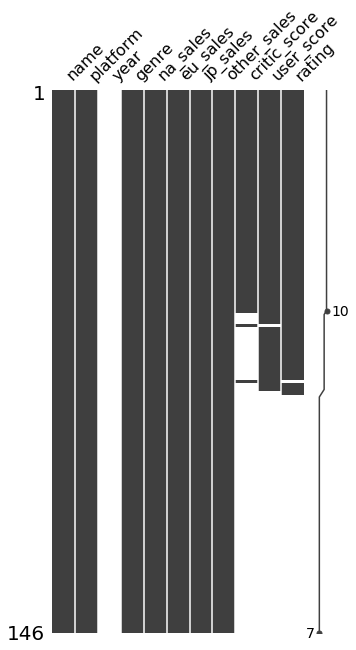

In [13]:
msno.matrix(msno.nullity_sort(df[df['year'].isna()], sort='descending'), 
            figsize=(5, 10))
plt.show()

Примерно у половины оставшихся так же отсутствуют и любые рейтинги. Сразу их удалим, так как они не имеют никаких важных для анализа данных:

In [14]:
df = df.dropna(subset=['year', 'user_score', 'critic_score'], how='all')

Посмотрим на топ-10 платформ по проценту оставшихся игр без даты:

In [15]:
(df.groupby('platform')['year']
   .apply(lambda x: x.isna().mean())
   .sort_values(ascending=False)
   .head(10))

platform
Wii     0.009893
X360    0.007937
3DS     0.007707
GBA     0.007326
XB      0.007290
PS2     0.006038
PS3     0.005275
DS      0.005140
PC      0.004107
GC      0.003610
Name: year, dtype: float64

In [16]:
df['year'].isna().mean()

0.004865449303219606

Пропусков сталось всего меньше половины процента от всего датафрейма, плюс по разным платформам они занимают тоже меньше процента. Удалим остатки:

In [17]:
df = df.dropna(subset=['year'])



---



Дальше по плану значительные пропуски.

Удалять их точно нельзя, потому что их очень много. Заполнять чем-то поля с оценками тоже будет не лучшей идеей, потому что, во-первых, отсутствующий рейтинг никак не может быть высчитан, и, во-вторых, нам в принципе и не нужно менять тип поля на *int*, потому что у рейтинга есть дробная часть.

С полем *rating* разберёмся ниже.





---



А дальше по плану - типы данных. 

Поле *user_score* имеет почему-то тип данных *object*. 

Взглянем поближе:

In [18]:
df['user_score'].sample(10, random_state=42)

5692     5.6
15758    NaN
6379     7.7
4253     6.9
1697     NaN
6118     5.6
15674    8.3
7096     6.7
4031     8.7
14625    tbd
Name: user_score, dtype: object

Видно странное значение -  **tbd**. Взглянем на срез по этому значению:

In [19]:
df[df['user_score'] == 'tbd']

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Как говорит интернет, tbd расшифровывается как *To Be Determined*, то есть *Подлежит Определению*. Возможно, на момент выгрузки информации в источнике было недостаточно данных. В любом случае, взять эту информацию негде, а столбец привести к типу *float* надо, поэтому заменим это на np.nan:

In [20]:
df['user_score'] = df['user_score'].replace({'tbd': np.nan}).astype('float')

В поле *year* все пропуски устранили, теперь можно сделать его целым числом:

In [21]:
df['year'] = df['year'].astype('int')

In [22]:
df.dtypes

name             object
platform         object
year              int64
genre            object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
critic_score    float64
user_score      float64
rating           object
dtype: object



---



Теперь посмотрим на каждое поле поближе, но сначала приведём все поля к нижнему регистру: 



In [23]:
for col in df.select_dtypes('object'):
    df[col] = df[col].str.lower()

Начнём с *name*. Посмотрим на самые частовстречающиеся названия:

In [24]:
games = df['name'].value_counts().head(100)
games.head(10)

need for speed: most wanted    12
madden nfl 07                   9
lego marvel super heroes        9
ratatouille                     9
fifa 14                         9
lego jurassic world             8
the lego movie videogame        8
terraria                        8
monopoly                        8
angry birds star wars           8
Name: name, dtype: int64

Посмотрим, равняется ли это количеству платформ, на которых вышла игра, и удалим повторы по платформам, если не равняется:

In [25]:
for game in games.index:
    if df[df['name'] == game]['platform'].nunique() == games[game]: continue
    
    df = df.drop_duplicates(subset=['name', 'platform'], 
                            keep='first').reset_index(drop=True)

Далее взглянем на поле *platform*:

In [27]:
df['platform'].value_counts()

ps2     2140
ds      2129
ps3     1318
wii     1301
x360    1249
psp     1203
ps      1190
pc       969
xb       817
gba      813
gc       552
3ds      515
psv      429
ps4      392
n64      318
xone     247
snes     239
sat      173
wiiu     147
2600     117
nes       98
gb        97
dc        52
gen       27
ng        12
ws         6
scd        6
3do        3
tg16       2
pcfx       1
gg         1
Name: platform, dtype: int64

Вроде бы с этим полем всё в порядке. 

Перейдём к *genre*:

In [28]:
df['genre'].value_counts()

action          3342
sports          2332
misc            1735
role-playing    1484
shooter         1311
adventure       1294
racing          1234
platform         878
simulation       860
fighting         842
strategy         678
puzzle           573
Name: genre, dtype: int64

Заменим *misc* на *other*, *role-playing* на *rpg*, а *platform* на *platformer*:

In [29]:
df['genre'] = df['genre'].replace({'misc': 'other', 
                                   'role-playing': 'rpg',
                                   'platform': 'platformer'})

df['genre'].value_counts()

action        3342
sports        2332
other         1735
rpg           1484
shooter       1311
adventure     1294
racing        1234
platformer     878
simulation     860
fighting       842
strategy       678
puzzle         573
Name: genre, dtype: int64

Перейдём к полям с продажами, создадим поле *total_sales* и посмотрим на максимальные цифры:

In [30]:
df['total_sales'] = df.filter(regex=r'_sales').sum(axis=1)
df['total_sales']

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16558     0.01
16559     0.01
16560     0.01
16561     0.01
16562     0.01
Name: total_sales, Length: 16563, dtype: float64

Цифры кажутся космическими, но некоторые игры и правда продаются такими тиражами.

Посмотрим на минимальные продажи во всех регионах:

In [32]:
null = df[(df['na_sales'] == 0)&
          (df['jp_sales'] == 0)&
          (df['eu_sales'] == 0)&
          (df['other_sales'] == 0)
         ]
null

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16524,g1 jockey 4 2008,ps3,2008,sports,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
16557,score international baja 1000: the official game,ps2,2008,racing,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


In [33]:
df = df.drop(null.index).reset_index(drop=True)

Это можно считать аномалией и можно удалить.

Посмотрим на распределение нулевых продаж по регионам:

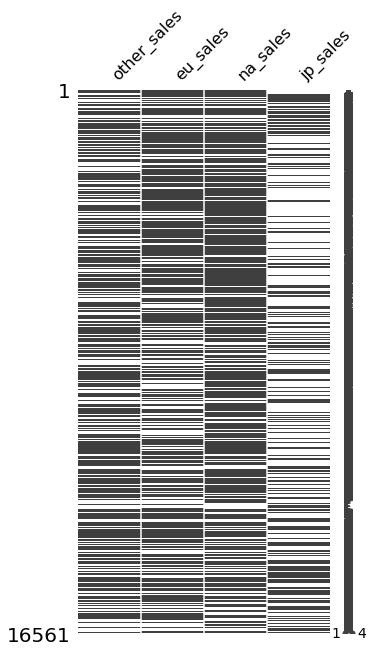

In [34]:
msno.matrix(
    (df.sort_values('year')[['other_sales', 'eu_sales', 'na_sales', 'jp_sales']]
       .replace({0: np.nan})), 
    figsize=(5,10))
plt.show()

Как известно, японский рынок видеоигр очень сильно отличается от остального мира, и в принципе на этом распределении наблюдается примерно такая картина. Примем пока что нули в продажах за крайне низкий показатель продаж в этом регионе (так как они у нас в миллионах).

Осталось поле с возратным рейтингом. Посмотрим в интернете, какие категории вообще есть: **EC, E, E10+, T, M, AO, RP**. 

Также посмотрим, какие категории имеются у нас:

In [35]:
df['rating'].value_counts(dropna=False)

NaN     6697
e       3957
t       2928
m       1554
e10+    1411
ec         8
k-a        3
rp         2
ao         1
Name: rating, dtype: int64

Видим много пропусков (заменим их на тектовый *nan*), а так же непонятную категорию **k-a**. Из того же интернета узнаём, что это старое обозначение категории **e**, заменим на неё:

In [36]:
# df['rating'] = df['rating'].fillna('NaN')
df['rating'] = df['rating'].replace({'k-a': 'e'}).fillna('nan')
df['rating'].value_counts()

nan     6697
e       3960
t       2928
m       1554
e10+    1411
ec         8
rp         2
ao         1
Name: rating, dtype: int64

С основной предобработкой закончили, перейдём непосредственно к анализу.



---



## Анализ данных
<a id='analisys'></a>
<a name='analisys'></a>
Посмотрим на разные графики, сделаем разные выводы

В этом разделе нам нужно попытаться найти закономерности, которые в ретроспективе влияли на успешность игр.

Начнём с чего-нибудь простенького. Например, посмотрим, сколько игр вообще выпускалось в разные года:

In [37]:
sns.set(rc={'figure.figsize':(15,7), 
            'figure.dpi':80,},
        palette = 'colorblind',
        style='ticks')

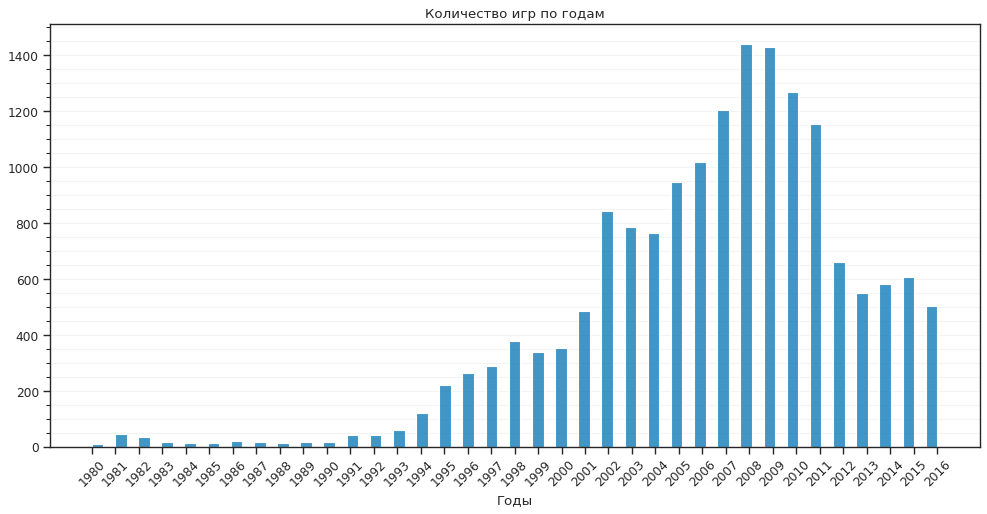

In [38]:
sns.histplot(df['year'], bins=df['year'].nunique()*2 - 1)
plt.xticks(ticks=df['year'].unique(), rotation=45)
plt.title('Количество игр по годам')
plt.xlabel('Годы')
plt.ylabel('')
plt.minorticks_on()
plt.grid(which='both', axis='y', alpha=0.2)
plt.show()

Интересно, что число выходящих игр достигло своего пика в 2008-2009 годах, и дальше начало падать.

Так же посмотрим, как менялись продажи игр каждой платформы по годам

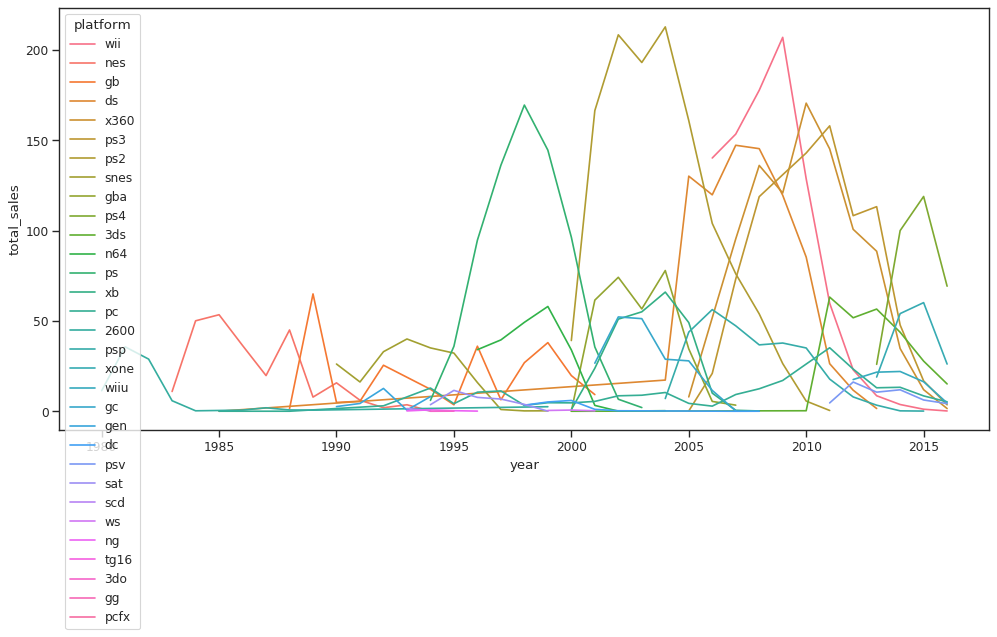

In [39]:
sns.lineplot(data=df, x='year', y='total_sales', hue='platform', ci=None, estimator='sum')

Получается не совсем понятная каша. Выберем только популярные платформы для анализа:

In [41]:
platforms = df.groupby('platform')['name'].nunique().sort_values(ascending=False)

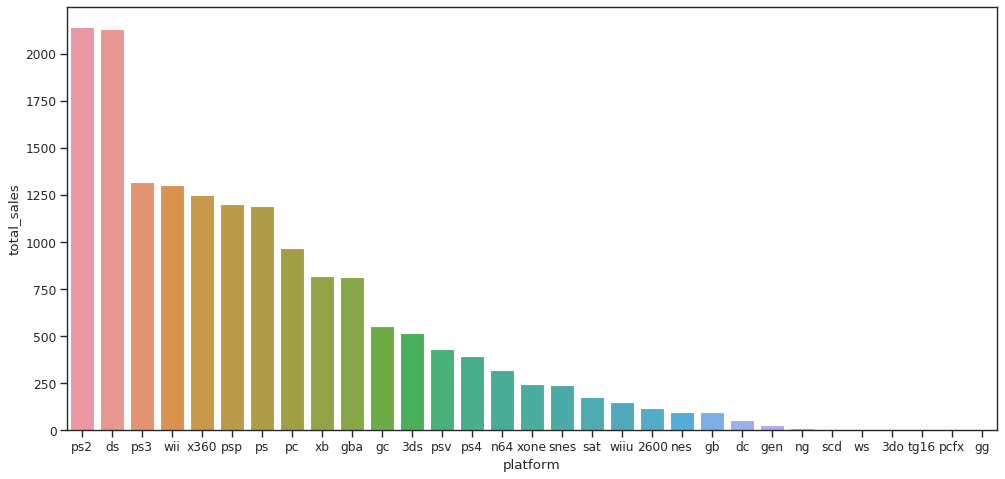

In [42]:
sns.barplot(data = df, 
            x = 'platform', 
            y = 'total_sales',
            estimator = len,
            ci = None,
            order = platforms.index)
plt.show()

Видно, что для анализа можно взять первые 10 платформ, как платформы с наибольшим количеством игр за всё время.

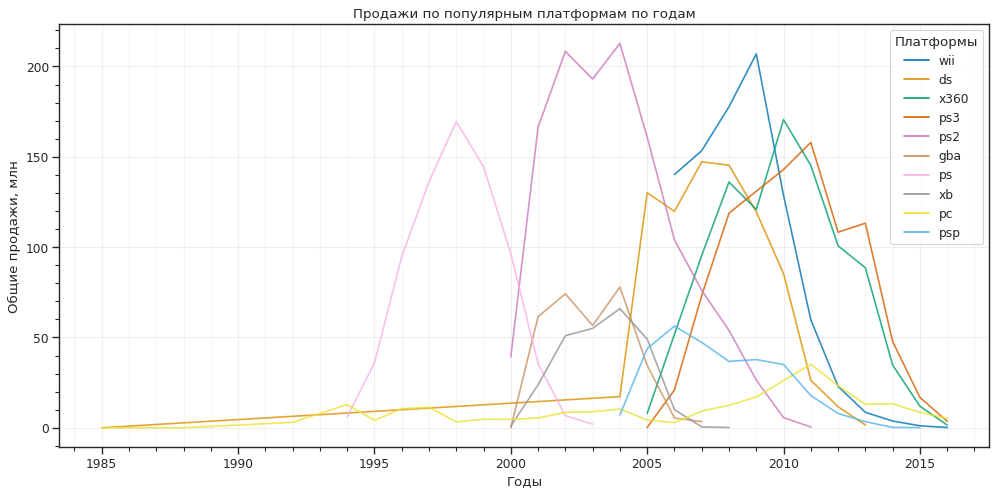

In [43]:
sns.lineplot(data=df.query('platform in @platforms.head(10).index'), 
             x='year', 
             y='total_sales', 
             hue='platform', 
             ci=None, 
             estimator='sum', 
             alpha=0.8)

plt.title('Продажи по популярным платформам по годам')
plt.ylabel('Общие продажи, млн')
plt.xlabel('Годы')
plt.legend(title='Платформы')

# plt.xlim(1999)
plt.minorticks_on()
plt.grid(which='major', alpha=0.3)
plt.grid(which='minor', axis='x', alpha=0.2)

Стало получше. На графике видно, что у платформы есть свой срок жизни, с пиком популярности примерно в середине. Посмотрим, сколько в среднем живут платформы:

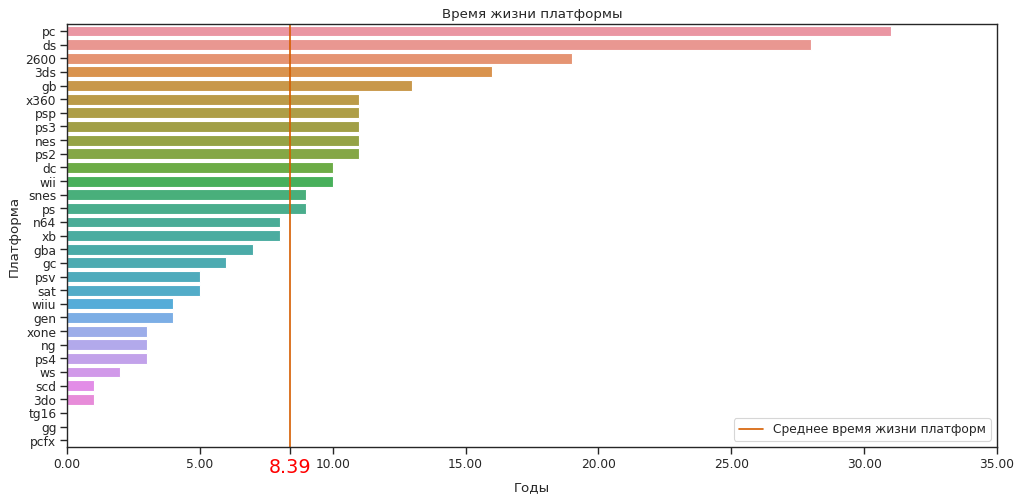

In [44]:
count_life = df.groupby('platform')['year'].agg(lambda x: x.max() - x.min()).sort_values(ascending=False)

sns.barplot(data = df,
            y ='platform',
            x ='year',
            ci = None,
            estimator = lambda x: x.max() - x.min(),
            order = count_life.index
            )

plt.axvline(count_life.mean(), 
            color='r', 
            label='Среднее время жизни платформ',
            )

plt.title('Время жизни платформы')
plt.ylabel('Платформа')
plt.xlabel('Годы')

plt.xticks(ticks=np.append(plt.xticks()[0], count_life.mean()))
plt.gca().get_xticklabels()[-1].set(color = 'red',
                                    size = 'x-large')
plt.legend()
plt.show()

Средний срок жизни платформы - 8.4 года.

В принципе, примерно такая картина на графике и наблюдается. Есть как платформы долгожители, которые существуют всё это время, так есть и более короткоживущие платформы. 

Можно сделать вывод, что платформа живёт в районе 9 лет, с пиком в год-два в середине жизни. Это наблюдение поможет решить нашу главную задачу - для прогнозов нужно использовать данные как минимум не старше 8 лет. Посмотрим на график платформ с 2008 по 2015 год

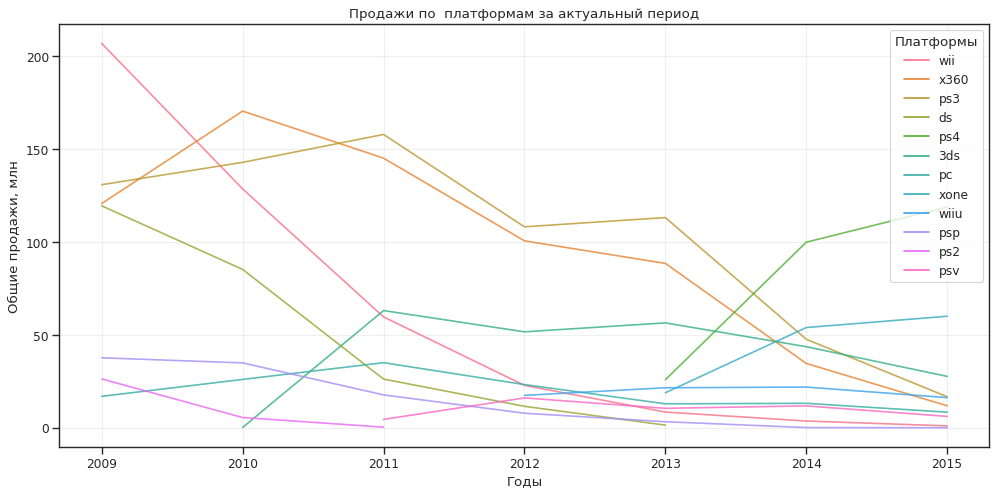

In [45]:
sns.lineplot(data=df.query('year > 2008 and year < 2016'), 
             x='year', 
             y='total_sales', 
             hue='platform', 
             ci=None, 
             estimator='sum', 
             alpha=0.8)

plt.grid(alpha=0.3)

plt.title('Продажи по  платформам за актуальный период')
plt.ylabel('Общие продажи, млн')
plt.xlabel('Годы')
plt.legend(title='Платформы')

plt.show()

Видно, что можно ограничиться ещё более коротким периодом - взять данные после 2011 года:

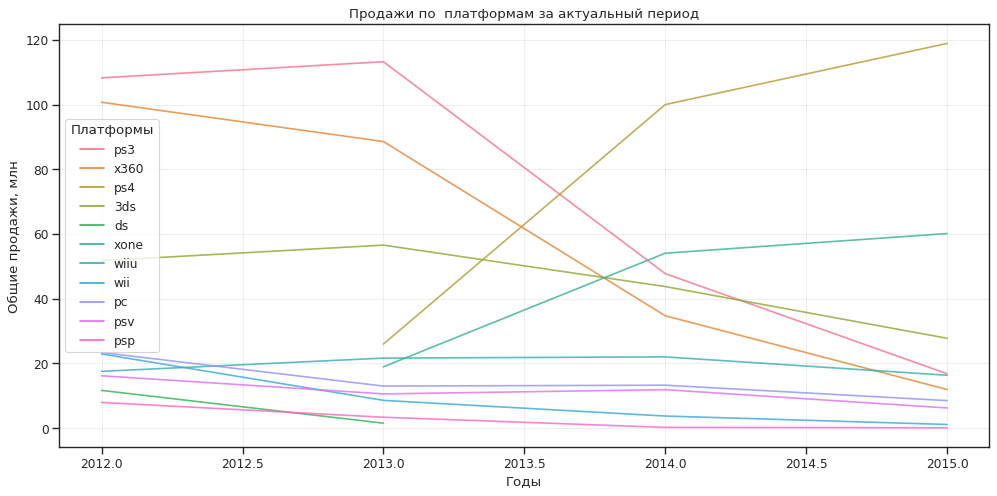

In [46]:
actual = np.arange(2012, 2016)

sns.lineplot(data=df.query('year in @actual'), 
             x='year', 
             y='total_sales', 
             hue='platform', 
             ci=None, 
             estimator='sum', 
             alpha=0.8)

plt.grid(alpha=0.3)

plt.title('Продажи по  платформам за актуальный период')
plt.ylabel('Общие продажи, млн')
plt.xlabel('Годы')
plt.legend(title='Платформы')

plt.show()

2016 год мы исключили, так как данные за 2016 год могут быть не полными.

Тут сходу видны платформы, которые только начинают рост - **ps4** и **xone**, которые точно нельзя обделять вниманием в рекламных кампаниях следующего года, тогда как **ps3** и **x360**, очевидно, доживают свой цикл, и их можно будет и пообделять.

Взглянем на размах количества продаж по всему миру по каждой платформе:

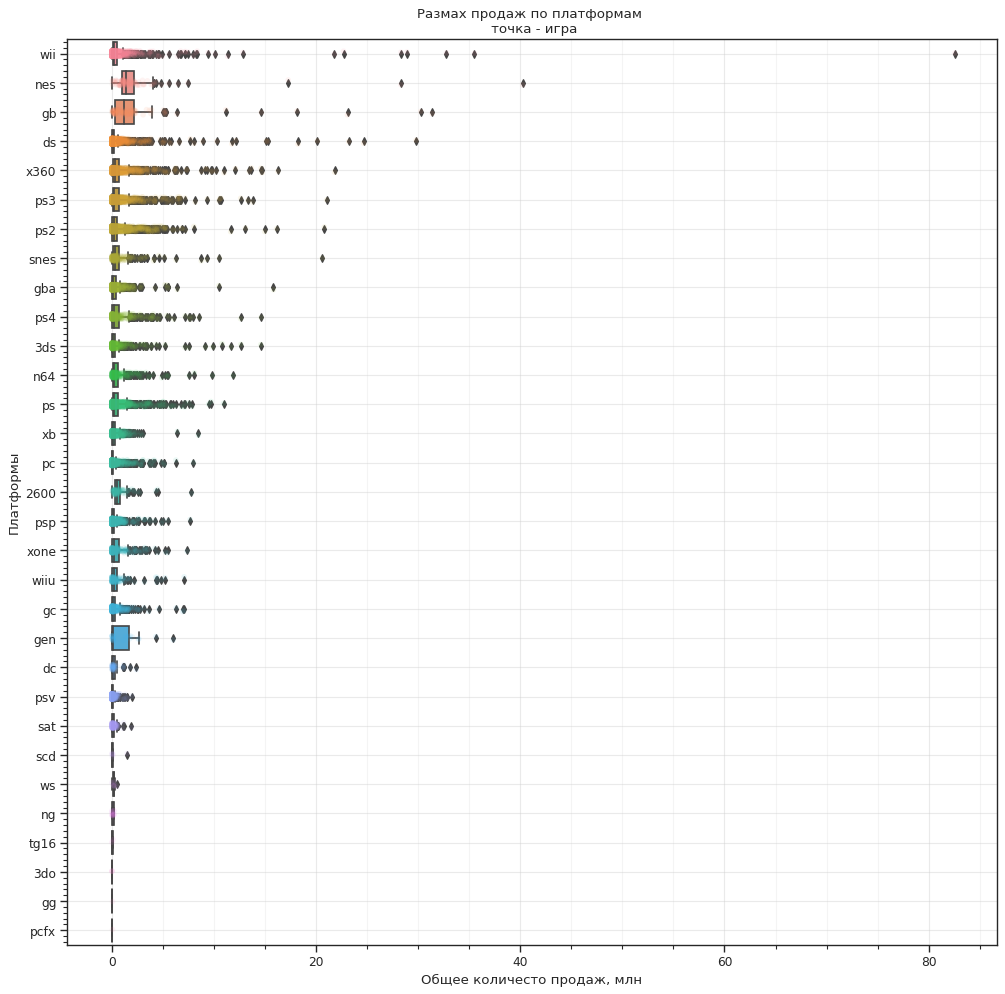

In [47]:
plt.figure(figsize=(15,15), dpi=80)

sns.stripplot(data=df, 
              y='platform', 
              x='total_sales', 
              alpha=0.1)

sns.boxplot(data=df, 
            x='total_sales', 
            y='platform')

plt.title('Размах продаж по платформам \n точка - игра')
plt.ylabel('Платформы')
plt.xlabel('Общее количесто продаж, млн')

plt.minorticks_on()
plt.grid(alpha=0.4)
plt.grid(which='minor', axis='x', alpha=0.2)

plt.show()

По этому графику можно увидеть примерно количество у платформы сверх-популярных игр. Уже сейчас можно увидеть, что **ps4** опережает **xone** по количеству таких игр, что говорит о популярности платформы.

Посмотрим так же на корреляции оценок пользователей и критиков и мировых продаж для платформы **ps3**, как одной из самых популярных и ещё актуальных (хоть и уже почти нет):

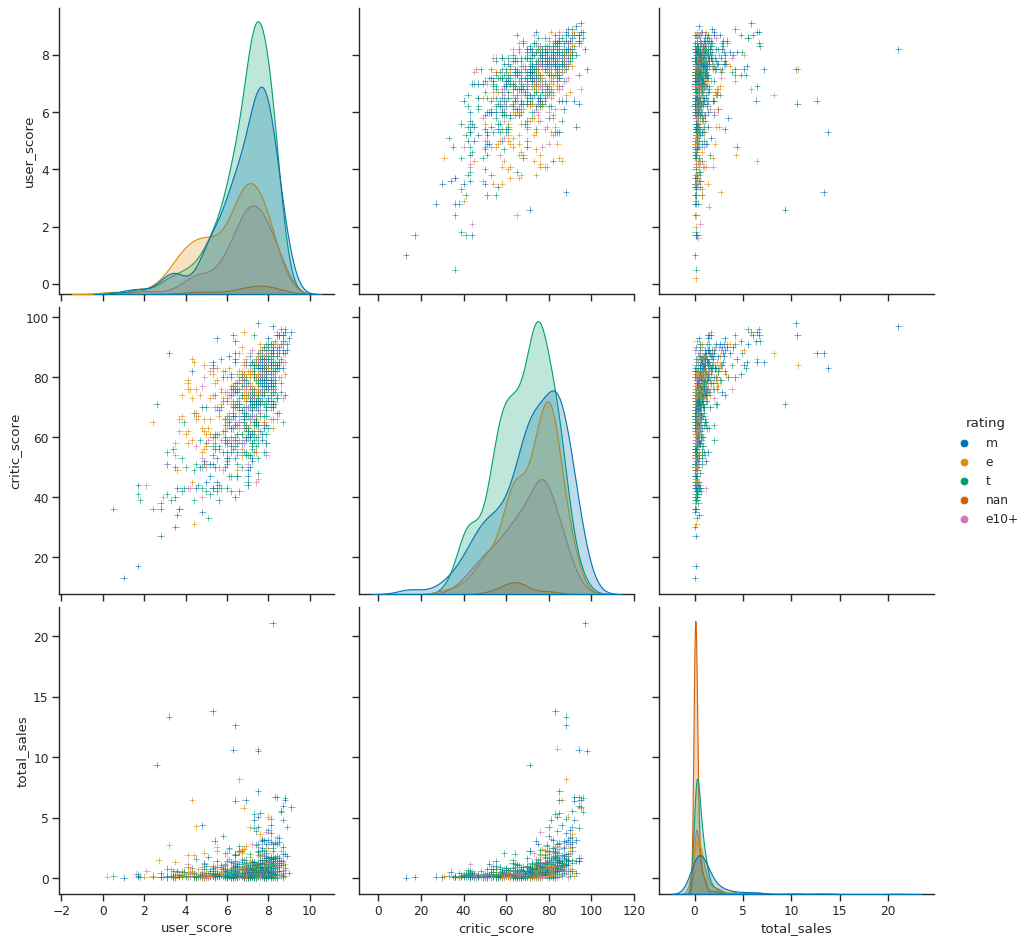

In [48]:
sns.pairplot(df.query('platform == "ps3"')[['user_score', 
                                            'critic_score', 
                                            'rating', 
                                            'total_sales']], 
             hue = 'rating', 
             kind = "scatter", 
             markers = '+',
             height = 4)

plt.show()

Видно, что рейтинг критиков может влиять на количество продаж, в то время как пользовательский рейтинг влияет не так сильно в силу своей природы (критики более объективно выполняют свою работу, в то время как пользователи ставят оценки субъективно). Взглянем на графики зависимости глобальных продаж от рейтинга критиков для других популярных платформ:

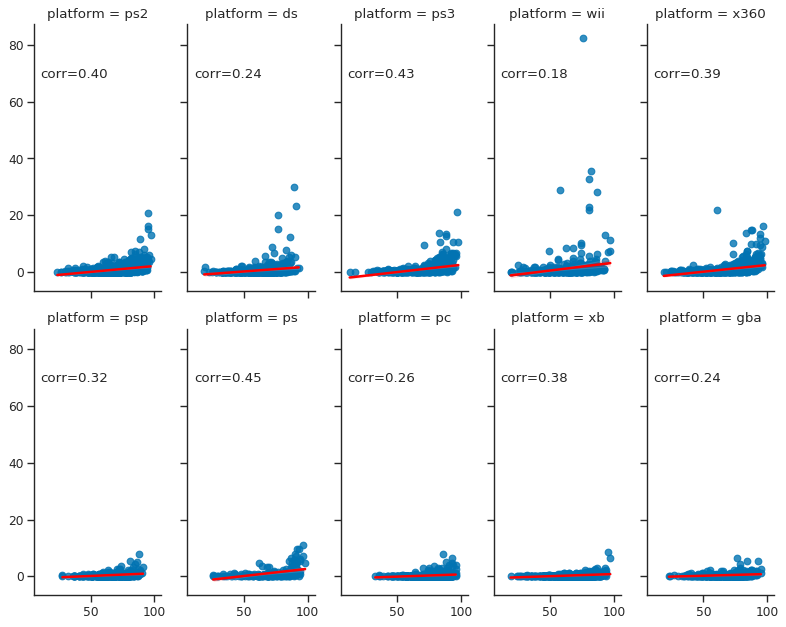

In [49]:
g = sns.FacetGrid(df.query('platform in @platforms.head(10).index'), 
                  col = 'platform',
                  col_wrap = 5,
                  height = 4,
                  aspect = 0.5,
                  col_order = platforms.head(10).index)

g.map(sns.regplot, 
      'critic_score', 
      'total_sales', 
      line_kws={'color':'red'})

def annotation_corr(data, **kws):
    corr = data['total_sales'].corr(data['critic_score'])
    ax = plt.gca()
    ax.text(0.05, 
            0.8, 
            'corr={:.2f}'.format(corr),
            transform=ax.transAxes)

g.map_dataframe(annotation_corr)

plt.show()

Графики расположены в порядке убывания популярности платформы, и можно заметить, что популярность платформы коррелирует с уровнем корреляции между оценками критиков и продажами игр.

Посмотрим так же на популярность разных жанров, отсортированные по суммарному количеству продаж:

In [50]:
genres = (df.groupby('genre')['total_sales']
            .sum()
            .sort_values(ascending=False)
            .index)

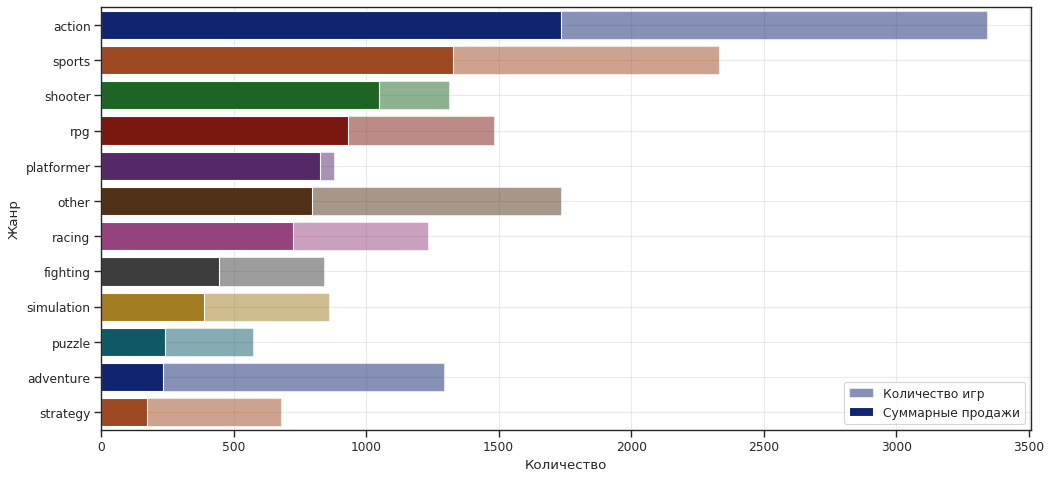

In [51]:
sns.countplot(data = df,
              y = 'genre',
              order = genres,
              alpha = 0.5,
              label = 'Количество игр',
              palette='dark'
              )

sns.barplot(data = df, 
            y = 'genre', 
            x = 'total_sales', 
            ci = None, 
            estimator = sum, 
            order = genres,
            label = 'Суммарные продажи',
            palette = 'dark')

plt.xlabel('Количество')
plt.ylabel('Жанр')
plt.grid(alpha=0.4)

plt.legend()
plt.show()

По графику видно интересную вещь - хоть лидерами и являются жанры *action* и *sports*, игр в этих жанрах выходит намного больше, чем в жанре *shooter* и *platformer*, хотя продажи у последних не так сильно отличаются.

Составим портреты пользователей для каждого региона:

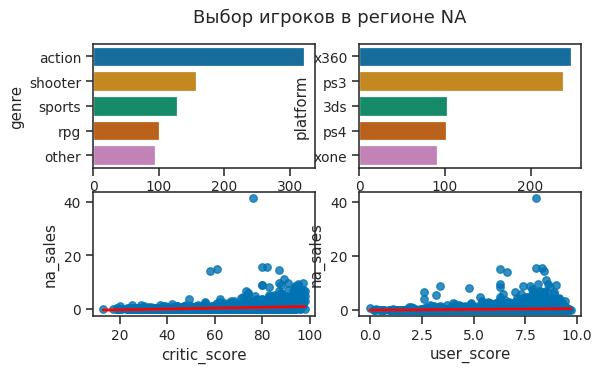

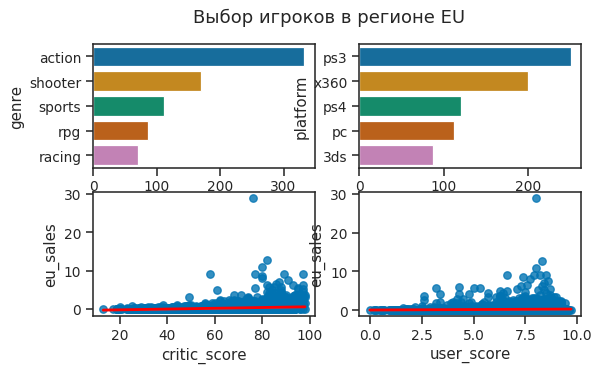

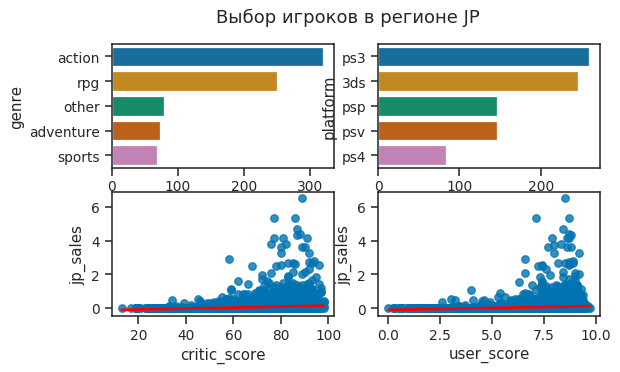

In [52]:
for loc in ['na', 'eu', 'jp']:
    fig = plt.figure()

    fig.set(size_inches = (7, 4),
            dpi = 90)

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    axes = [ax1, ax2, ax3, ax4]
    
    plt.suptitle(f'Выбор игроков в регионе {loc.upper()}')

    for ax, col in zip(axes, ['genre', 'platform', 'critic_score', 'user_score']):
        data = (df.query('year > 2010 and year != 2016')
                  .sort_values(f'{loc}_sales', ascending=False))
        
        if col.endswith('_score'):
            sns.regplot(ax = ax, 
                        data = df, 
                        x = col, 
                        y = f'{loc}_sales', 
                        line_kws = {'color': 'red'})
        else:
            sns.countplot(ax = ax, 
                          y = data.head(1000)[col], 
                          order = data.head(1000)[col].value_counts().head(5).index)

    plt.show()

На этих графиках видно, что при планировании рекламных кампаний для каждого региона нужно учитывать предпочтения пользователей из этого региона, потому что они довольно сильно отличаются в разных регионах.

Посмотрим на влияние возрастного рейтинга игры на продажи в каждом из регионов:

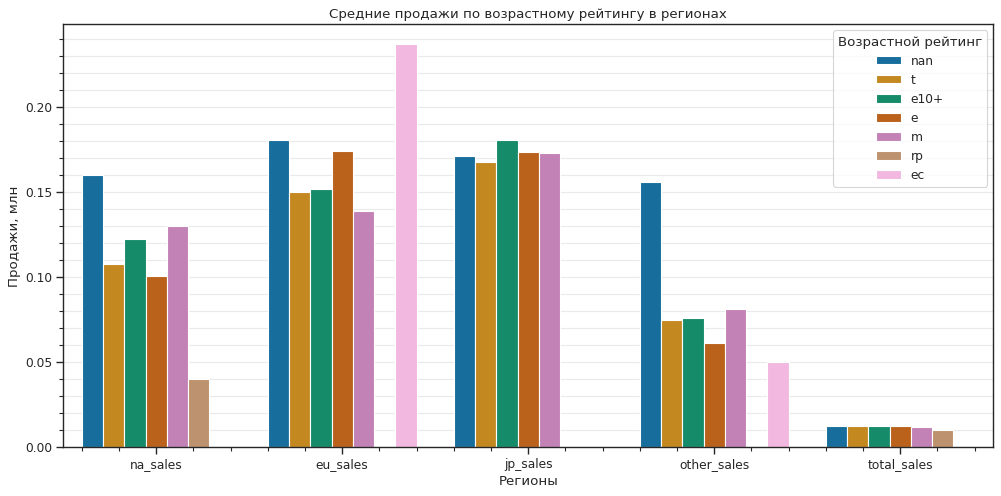

In [58]:
df_loc = pd.DataFrame()
for loc in df.filter(regex=r'_sales'):
    data = df.sort_values(loc).head(1000)
    data['loc'] = loc
    df_loc = df_loc.append(data)

sns.barplot(
    data = df_loc,
    x = 'loc',
    y = 'total_sales',
    ci = None,
    hue = 'rating',
)

plt.title('Средние продажи по возрастному рейтингу в регионах')
plt.ylabel('Продажи, млн')
plt.xlabel('Регионы')
plt.legend(title='Возрастной рейтинг')

plt.minorticks_on()
plt.grid(which='both', axis='y', alpha=0.4)

plt.show()

Тут видно, что в разрезе регионов на продажи игр влияют так же и возрастные рейтинги. 

Перейдём к проверке гипотез.

## Проверка статистических гипотез
<a id='hypothesis'></a>
<a name='hypothesis'></a>
Посмотрим, можем ли мы вообще делать какие-либо выводы на основе наших данных.

Так как мы основываем часть наших выводов на продажах игр для каждой платформы, проверим, можем ли мы вообще считать эти выводами значимыми.



In [59]:
for platform in platforms.head(10).index:
    print(np.std(df.query('platform == @platform')['total_sales']))

1.1414982002409706
1.4331099592892478
1.3973663795956743
3.1471721654091063
1.621690631543382
0.5211405635229492
1.0563626463170026
0.6768316261843583
0.5363625663634608
0.8980767194076043


$H_0$ - средние продажи для двух платформ не отличаются.

$H_1$ - средние продажи для двух платформ отличаются.


*equal_var* сделаем *False*, так как отклонения выборок отличаются. Доверительный интервал примем за стандартные 5 процентов

In [60]:
def pv_heatmap(compares, compare_column, dataframe=df, equal_var=False, alpha=0.05):
    val_list = dataframe[compares].unique()
    pv_matrix = pd.DataFrame(index=val_list, columns=val_list)

    for index in pv_matrix.index:
        for column in pv_matrix:
            
            pval = sp.stats.ttest_ind(
                dataframe.loc[dataframe[compares] == index, compare_column].dropna(), 
                dataframe.loc[dataframe[compares] == column, compare_column].dropna(),
                equal_var=equal_var).pvalue
            
            pv_matrix.loc[index, column] = pval

    plt.figure(figsize=(4,4))
    sns.heatmap(pv_matrix.astype('float')<alpha, cbar=False, annot=True)
    plt.title(f'Результаты проверки нулевой гипотезы на равенство средних\n{compare_column} по {compares}')
    plt.xlabel('0 - Значимых отличий нет\n1 - Отличия значимы')
    
    plt.show()

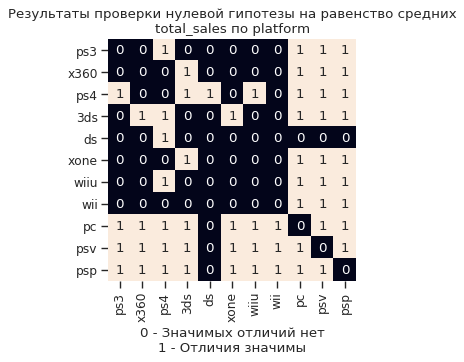

In [61]:
pv_heatmap('platform', 'total_sales', df.query('year in @actual'))

Видим, что отличий нет в основном внутри семейства платформ и внутри поколения. 

Проверим так же значимость различий между оценками критиков для разных платформ за актуальный период:

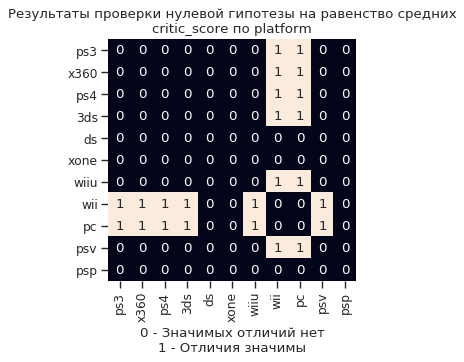

In [62]:
pv_heatmap('platform', 'critic_score', df.query('year in @actual'))

Из этого можно понять, что отценки критиков влияют на продажи примерно одинаково для всех платформ (исключением является разве что ПК и Wii).

Посмотрим на то же самое для жанров.

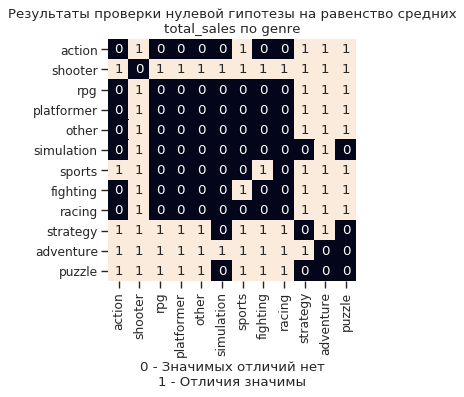

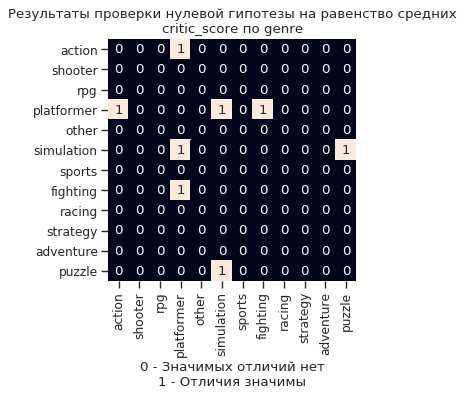

In [63]:
pv_heatmap('genre', 'total_sales', df.query('year in @actual'))
pv_heatmap('genre', 'critic_score', df.query('year in @actual'))

По жанрам картина точно такая же.

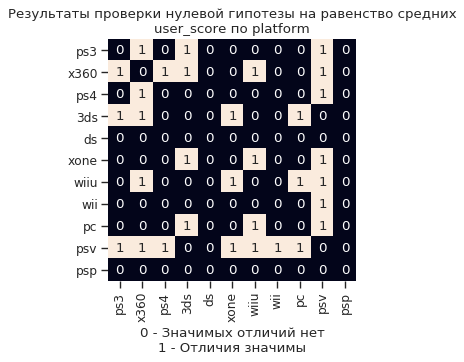

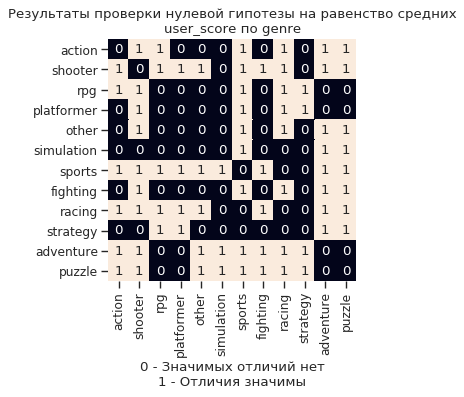

In [64]:
pv_heatmap('platform', 'user_score', df.query('year in @actual'))
pv_heatmap('genre', 'user_score', df.query('year in @actual'))

## Выводы
<a id='conclusions'></a>
<a name='conclusions'></a>
Сделаем, наконец, выводы

Проанализировав данные и подкрепив свои выводы с помощью статистических тестов, мы можем сделать определённые выводы по нашей задаче.

- Если экстраполировать сделанные наблюдения, можно утверждать, что новое поколение платфрм (**Xone, PS4**) будут активно расти в следующем году, после чего будут ещё 1-2 года на пике. Это значит, что основную ставку в глобальных рекламных кампаниях стоит делать на эти две платформы.

- Так же не стоит совсем обделять вниманием уходящие платформы - они ещё очень популярны в регионах, и продажи хоть и падают, но будут в следующем году на достаточном уровне

- Самые популярные жанры - **action** и **sports**. Однако у них одно из самых низких отношений объёма продаж к выпущенным играм, что уменьшает шансы угадать с выбором удачной игры. Я бы уделил как минимум не меньше внимания жанру **shooter** и **platformer**, потому что там это отношение одно из самых низких.

- Не стоит забывать про региональные рынки. Мы выяснили, что в разных регионах предпочтения пользователей по жанрам и консолям отличаются, и в регионах было бы целесообразно уделять внимание локальным кампаниям помимо глобальных (кроме Японии - там интересы пользователей отличаются очень сильно от остального мира и стоит сделать свою кампанию). 

- В Северной Америке и Европе один из самых популярных жанров - **shooter**, и он ещё и очень удачно имеет большое отношение продаж к количеству выпущенных игр (в отличие от жанра **action**), так что стоит в этих регионах активней рекламировать игры этого жанра. В этих регионах популярны консоли *нового* и *уходящего* поколения. 

- В Европе ещё нужно учесть популярность *персональных компьютеров* в качестве игровых станций.

- В Японии популярен жанр **rpg** и *портативные* консоли, а так же совсем не популярны консоли семейства *xbox*. Это стоит учитывать 

- Продажи игр так же имеют определённую зависимость от оценок критиков. Стоит уделять больше внимания играм, о которых хорошо отзываются игровые издания, независимо от платформы.

- Так же не стоит забывать про возрастной рейтинг игр. Он так же отличается от региона к региону.